# Beta de una acción

Este notebook es el soporte del artículo http://estrategiastrading.com/beta-de-una-accion/

In [1]:
#importaciones
import matplotlib.pylab as plt
import pandas as pd
from pandas_datareader import data as web
import numpy as np
import statsmodels.api as sm
#configuración gráficos
%matplotlib inline 
plt.rcParams['figure.figsize']= 16,8
plt.style.use('seaborn-darkgrid')
import seaborn as sns

In [2]:
# Cargar datos 
start = pd.Timestamp ('2005-01-01')
end = pd.Timestamp ('2017-4-30')

symbols = ['AAPL', 'SPY']
df = pd.DataFrame()
for sym in symbols:
    df[sym] = web.DataReader(sym,'yahoo' ,start,end)['Adj Close']  

In [3]:
# ajustar a fin de mes
dfmes = df.resample('BM').last() 

In [4]:
dfmes.head()

,AAPL,SPY
Date,,
2005-01-31,4.961087,92.183865
2005-02-28,5.788150,94.110858
2005-03-31,5.376554,92.389305
2005-04-29,4.652713,90.658377
2005-05-31,5.130112,93.579811


# Retornos

In [5]:
dfmes_returns = dfmes.pct_change()
dfmes_returns = dfmes_returns.dropna()

## Gráfico

Comienzo mirando la evolución de los retornos en un gráfico

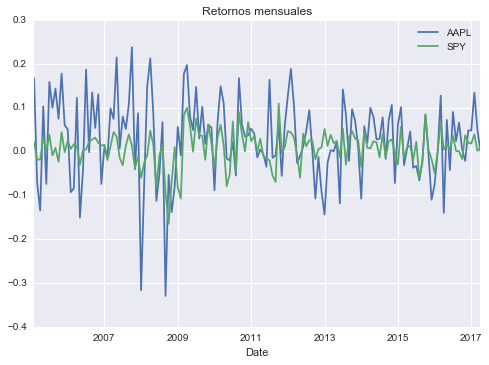

In [6]:
dfmes_returns.plot()
plt.title ('Retornos mensuales');

Bueno, no es el mejor gráfico del mundo, pero si que puedo ver que AAPL tiene unos rendimientos mucho más volátiles que su benchmark.

En un histograma se puede ver mejor

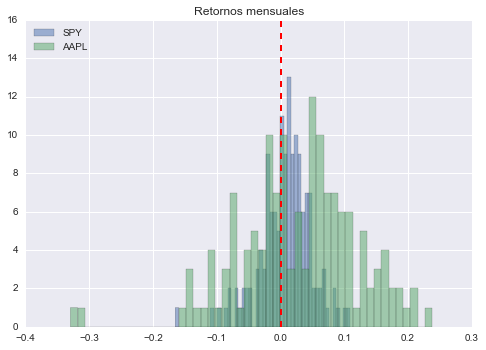

In [7]:
dfmes_returns.SPY.hist(bins=50,alpha=0.5, label = 'SPY')
dfmes_returns.AAPL.hist(bins=50, alpha=0.5, label = 'AAPL')
plt.legend(loc='upper left')
plt.ylim([0, 16])
plt.title ('Retornos mensuales');
plt.axvline(x=0, color='r', linestyle='dashed', linewidth=2);

##  Calculo Beta

In [8]:
def calc_stats(df):
  
    X = sm.add_constant(df.iloc[:,1])
    model = sm.OLS(df.iloc[:,0],X).fit()

    beta = model.params["SPY"]
    alpha = model.params["const"]
    r2 = model.rsquared
    return beta, alpha, r2

In [9]:
estats = (calc_stats(dfmes_returns))
estats 

(1.2796585411920307, 0.018269166005701661, 0.30701023522804216)

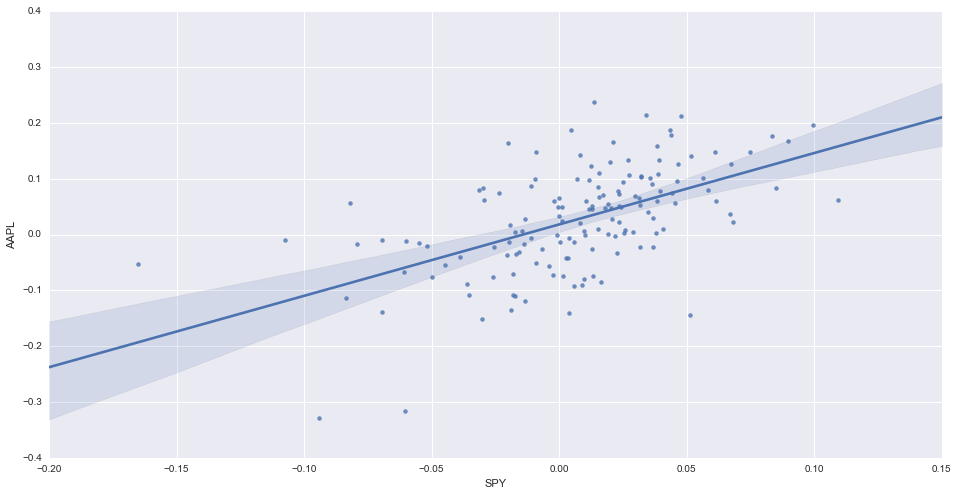

In [10]:
import seaborn as sns
f, ax = plt.subplots(figsize=(16,8))
sns.regplot(dfmes_returns.iloc[:,1], dfmes_returns.iloc[:,0]);

## Rolling Beta

In [11]:
def rolling_stats(df, window=5):
    
    res = pd.DataFrame(index=df.index)

    for i in range(0,len(df.index)):

        if len(df) - i >= window:
            periodo = df.iloc[i:window+i,:]
            
            beta,alpha,r2 = calc_stats(periodo)
            res.set_value(periodo.tail(1).index[0],"beta",beta)
            res.set_value(periodo.tail(1).index[0],"alpha",alpha)
            res.set_value(periodo.tail(1).index[0],"r2",r2)
            
    res = res.dropna()
    return res

In [12]:
df_rolling = rolling_stats(dfmes_returns, window=36)

df_rolling.head()

,beta,alpha,r2
Date,,,
2008-01-31,2.913614,0.025039,0.385609
2008-02-29,2.891108,0.022176,0.394746
2008-03-31,2.754405,0.028185,0.352990
2008-04-30,2.725062,0.032939,0.367357
2008-05-30,2.749831,0.033590,0.365880


In [13]:
df_rolling.tail(1)

,beta,alpha,r2
Date,,,
2017-04-28,1.432915,0.006254,0.422917


In [14]:
df_rolling.describe()

,beta,alpha,r2
count,112.000000,112.000000,112.000000
mean,1.291043,0.019688,0.334178
std,0.522663,0.014216,0.134441
min,0.594154,-0.003497,0.081351
25%,0.923003,0.005821,0.185968
50%,1.203890,0.021516,0.394644
75%,1.489369,0.032793,0.438732
max,2.913614,0.043352,0.518022


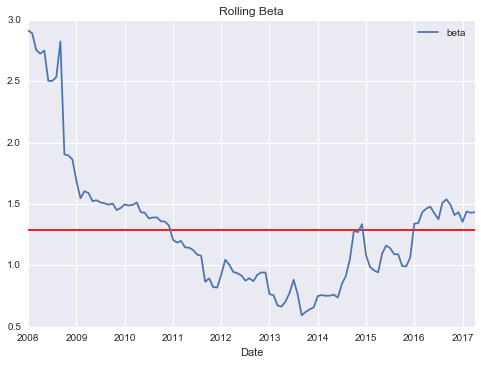

In [15]:
# plot rolling beta
ax = df_rolling[["beta"]].plot(title="Rolling Beta")
ax.grid(True)
ax.legend(loc=0)
ax.hlines(df_rolling[["beta"]].mean(),start,end, color= 'r')
plt.show()

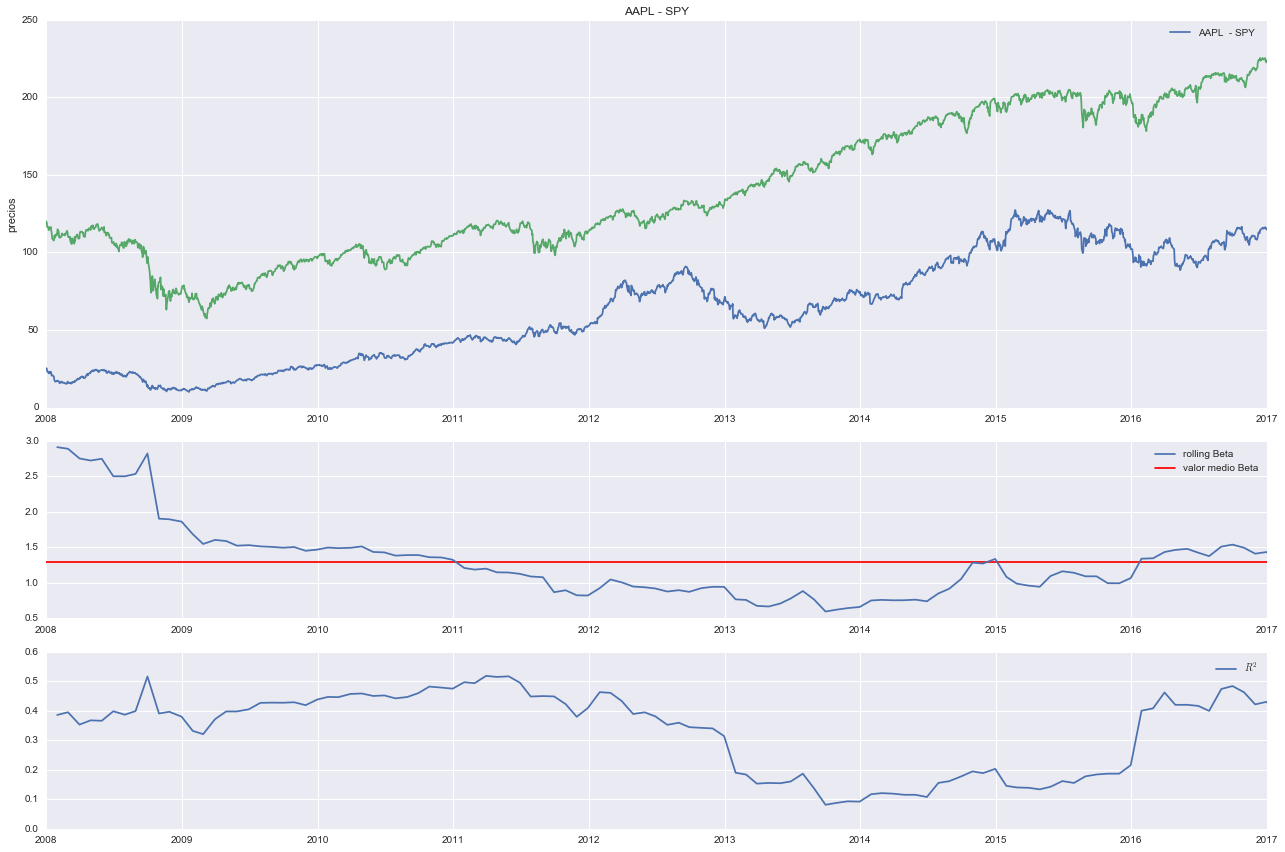

In [16]:
fig = plt.figure(figsize = (18,12))
grid_size= (4,1)

ax1 = plt.subplot2grid(grid_size, (0,0), rowspan = 2)
ax1.plot(df)
ax1.set_title('AAPL - SPY')
ax1.legend(['AAPL  - SPY '], loc = 0)
ax1.set_ylabel('precios')
ax1.set_xlim(["2008-1-01", "2017-1-01"])

ax2 = plt.subplot2grid(grid_size, (2,0))
ax2.plot(df_rolling[["beta"]])
ax2.hlines(df_rolling[["beta"]].mean(),start,end, color= 'r')
ax2.legend(['rolling Beta','valor medio Beta'], loc = 0)
ax2.set_xlim(["2008-1-01", "2017-1-01"])

ax3 = plt.subplot2grid(grid_size, (3,0))
ax3.plot(df_rolling[["r2"]],label=r"$R^2$")
ax3.legend(loc = 0)
ax3.set_xlim(["2008-1-01", "2017-1-01"])
ax3.set_xlim(["2008-1-01", "2017-1-01"]);

fig.tight_layout()

souces:http://blog.aboveindex.com/calculating-beta/